In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import biogeme.vns as vns
import biogeme.database as db

# Pareto reader

This notebook is used to display the information contained in the Pareto set generated by the algorithm, and saved in the pickle file. 

We need the following just to know the sample size. 

In [2]:
df = pd.read_csv('optima.dat', '\t')

database = db.Database('optima', df)

globals().update(database.variables)

exclude = ((Choice == -1) + (CostCarCHF < 0)) > 0
database.remove(exclude)

sampleSize = database.getSampleSize()
sampleSize

1906

The information about the approximation of the Pareto set is saved regularly by the algorithm in a pickle file. We first open it. 

In [3]:
pickleFile = 'optimaPareto.pickle'

In [4]:
pareto = vns.paretoClass(20, archiveInputFile=pickleFile)

In [5]:
print(f'Number of pareto solutions: {len(pareto.pareto)}')

Number of pareto solutions: 16


We calculate the AIC and the BIC for non dominated each model.

In [6]:
def AIC(k, LL):
    """Calculate the Aikaike Information Criterion for a model with k parameters and final log liklelihood LL"""
    return 2 * k - 2 * LL

In [7]:
def BIC(k, LL):
    """Calculate the Bayesian Information Criterion for a model with k parameters and final log liklelihood LL"""
    return k * np.log(sampleSize) - 2 * LL


## List of Pareto solutions: performance measures

In [8]:
bestBIC = None
bestAIC = None
summary = []
besti = -1
bestj = -1
for p in pareto.pareto:
    res = ''
    for t, r in zip(p.objectivesNames, p.objectives):
        res += f'{t}: {r}\t'
    L = p.objectives[0]
    k = p.objectives[1]
    A = AIC(k, -L)
    B = BIC(k, -L)
    res += f'BIC = {B:.3f}\tAIC = {A:.3f}'
    summary.append(res)
    if bestBIC is None or B < bestBIC:
        bestBIC = B
        besti = len(summary) - 1
    if bestAIC is None or A < bestAIC:
        bestAIC = A
        bestj = len(summary) - 1
for i in range(len(summary)):
    if i == besti:
        if i == bestj:
            pre = f'{i+1:3} **'
        else:
            pre = f'{i+1:3} B*'
    elif i == bestj:
        pre = f'{i+1:3} A*'
    else:
        pre = f'{i+1:3}   '
    print(f'{pre} {summary[i]}')

  1    Neg. log likelihood: 1017.9363783581521	#parameters: 12	BIC = 2126.506	AIC = 2059.873
  2    Neg. log likelihood: 1018.3166441013027	#parameters: 11	BIC = 2119.714	AIC = 2058.633
  3    Neg. log likelihood: 1038.3817802782057	#parameters: 8	BIC = 2137.186	AIC = 2092.764
  4    Neg. log likelihood: 1027.5880900079862	#parameters: 9	BIC = 2123.151	AIC = 2073.176
  5    Neg. log likelihood: 983.8820141622863	#parameters: 15	BIC = 2081.055	AIC = 1997.764
  6    Neg. log likelihood: 970.820271051317	#parameters: 16	BIC = 2062.485	AIC = 1973.641
  7    Neg. log likelihood: 1019.2635912178159	#parameters: 10	BIC = 2114.055	AIC = 2058.527
  8    Neg. log likelihood: 934.1075587174586	#parameters: 53	BIC = 2268.512	AIC = 1974.215
  9    Neg. log likelihood: 1056.5707378462307	#parameters: 7	BIC = 2166.011	AIC = 2127.141
 10 B* Neg. log likelihood: 955.5061090802105	#parameters: 19	BIC = 2054.515	AIC = 1949.012
 11    Neg. log likelihood: 964.9036928473397	#parameters: 18	BIC = 2065.757	A

## List of Pareto solutions: model specifications

In [9]:
counter = 0 
for p in pareto.pareto:
    counter += 1
    print(f'*************** Model {counter} ************************')
    print(p)
    print('\n')
    

*************** Model 1 ************************
CNL alpha est.-------------------
Alternative pt [0]
-------------------
Cte. 
PT travel time [generic] <Subscription>
PT travel cost_Box-Cox_cost [alt. spec.] 
Transfers [alt. spec.] 
PT Waiting time_log [alt. spec.] 
--------------------
Alternative car [1]
--------------------
Cte. 
Car travel time [generic] <Subscription>
Car travel cost_Box-Cox_cost [alt. spec.] 
-------------------
Alternative sm [2]
-------------------
Distance [alt. spec.] 

Neg. log likelihood: 1017.9363783581521
#parameters: 12


*************** Model 2 ************************
CNL alpha est.-------------------
Alternative pt [0]
-------------------
Cte. 
PT travel time_sqrt [alt. spec.] 
PT travel cost_Box-Cox_cost [alt. spec.] 

PT Waiting time_log [alt. spec.] 
--------------------
Alternative car [1]
--------------------
Cte. 
Car travel time_sqrt [alt. spec.] 
Car travel cost_Box-Cox_cost [alt. spec.] 
-------------------
Alternative sm [2]
---------------

## List of Pareto solutions: illustration

The plot below illustrates all models considered by the algorithm. Each model corresponds to one point in the graph. 

- The x-coordinate corresponds to the negative log likelihood of the model, and the y-coordinate to the number of parameters. 
- The larger circles correspond to all models that are not dominated. 
- The crosses corresponds to model that happened to be non dominated at some point during the course of the algorithm, but have been removed from the Pareto set afterwards, as a dominating model has been identified.
- Finally, the small dots corresponds to models that have been considered, but rejected because dominated by another model already in the set. 

In [10]:
objectives = list(pareto.pareto)[0].objectivesNames
objectives

['Neg. log likelihood', '#parameters']

In [11]:
par_obj = [p.objectives for p in pareto.pareto]
par_x, par_y = zip(*par_obj)

In [12]:
con_obj = [p.objectives for p in pareto.considered]
con_x, con_y = zip(*con_obj)

In [13]:
rem_obj = [p.objectives for p in pareto.removed]
rem_x, rem_y = zip(*rem_obj)

In [14]:
x_buffer = 10
y_buffer = 0.1

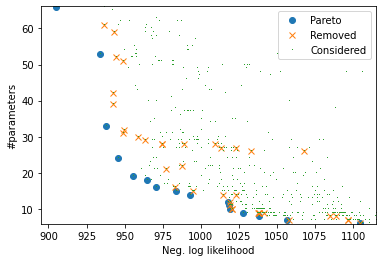

In [15]:
plt.axis([min(par_x)-x_buffer,
          max(par_x)+x_buffer,
          min(par_y)-y_buffer,
          max(par_y)+y_buffer])
plt.plot(par_x, par_y, 'o', label='Pareto')
plt.plot(rem_x, rem_y, 'x', label='Removed')
plt.plot(con_x, con_y, ',', label='Considered')
plt.xlabel(objectives[0])
plt.ylabel(objectives[1])
plt.legend()